<a href="https://colab.research.google.com/github/jelmerbe/EGR371/blob/main/Maersk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install networkx
!pip install basemap

In [5]:
#install dependencies 
import numpy as np 
from pandas import read_csv
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap

Download and clean data 

In [6]:
#import travel data 
routes_df = pd.read_csv('Maersk_data_all_time.csv', delimiter = ',')
#routes_df['port_ID'] = pd.to_numeric(routes_df['port_ID'].astype(str), 'coerce')

#import port data 
ports_df = pd.read_csv('port_data.csv')


# Edges 

Create routes dataset, where each row represents a unique travel route (edge) and count of how many times this route is travelled 

In [7]:
# Turn into numpy array
np.set_printoptions(suppress=True) 
schedule = np.genfromtxt('Maersk_data_all_time.csv', delimiter = ',', usecols=np.arange(0,9))
print(schedule)
schedule = np.column_stack([schedule[1:,0], schedule[1:,7], schedule[1:,8]])

print(schedule[1:10, :])

[[     nan      nan      nan ...      nan      nan      nan]
 [34480.        nan      nan ...      nan     1.      32.  ]
 [33770.        nan      nan ...      nan     1.      40.43]
 ...
 [60390.        nan      nan ...      nan   365.      20.73]
 [57777.        nan      nan ...      nan   365.      14.67]
 [57830.        nan      nan ...      nan   365.      23.53]]
[[33770.       1.      40.43]
 [31140.       1.       8.5 ]
 [31140.       1.       3.65]
 [31140.       1.      19.63]
 [34690.       1.      97.15]
 [31140.       1.       9.07]
 [31140.       1.       4.75]
 [31140.       1.      10.03]
 [34690.       1.      73.4 ]]


In [8]:

#Create new array with all possible routes 
n = len(schedule[:,1])
routes_us = np.zeros((n, 5)) # PORT1, PORT2, #ships on route, RouteID, time_at_origin

for i in range (0,n-1): 
  if schedule[i,1] == schedule[i+1, 1]: #Check if the same ship 

    #Route already exists so increase count

    if (schedule[i,0] in routes_us[:i,0]) and (schedule[i+1,0] in routes_us[:i, 1]):
      loc = np.where(schedule[i,0] == routes_us[:i,0])
      routes_us[loc,2] = routes_us[loc, 2] + 1  #increase #ships on route 
      routes_us[loc,4] = routes_us[loc,4] + schedule[loc,2]/ routes_us[loc,2]

    #Route does not exist so create new route  
    else: 
      routes_us[i, 0] = schedule[i, 0]      #input origin port
      routes_us[i, 1] = schedule[i+1, 0]    #input dest port 
      routes_us[i,2] = routes_us[i, 2] + 1  #increase #ships on route 
      routes_us[i,3] = i # Add routeID to data
      routes_us[i,4] = schedule[i,2] #Time at Origin Port


#Print routes_us
np.set_printoptions(suppress=True) #surpress scientific notation 
print(routes_us)
 

[[34480.         33770.            15.             0.
    106.18332778]
 [33770.         31140.             7.             1.
    104.82921429]
 [31140.         31140.            70.             2.
     41.07911244]
 ...
 [    0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.        ]
 [    0.             0.             0.             0.
      0.        ]]


In [9]:
# delete empty routes 
routes_us = routes_us[~np.all(routes_us == 0, axis = 1)]


# Delete routes that stay in same port (inter terminal travel)
loc = np.where(routes_us[:, 0] == routes_us[:,1])
routes_us = np.delete(routes_us, loc, 0)
print(routes_us)

[[34480.         33770.            15.             0.
    106.18332778]
 [33770.         31140.             7.             1.
    104.82921429]
 [31140.         34690.            69.             4.
     94.58815698]
 ...
 [38550.         45570.             3.          3263.
     17.72833333]
 [45570.         45550.             2.          3264.
     79.68      ]
 [45550.         45755.             3.          3265.
     49.40833333]]


In [10]:
#Turn this dataset into pandas dataframe 
routes_df = pd.DataFrame(routes_us, columns = ['Origin', 'Destination', 'Number of ships', 'Route_ID', 'Time at Origin'])
print(routes_df)

      Origin  Destination  Number of ships  Route_ID  Time at Origin
0    34480.0      33770.0             15.0       0.0      106.183328
1    33770.0      31140.0              7.0       1.0      104.829214
2    31140.0      34690.0             69.0       4.0       94.588157
3    34690.0      31140.0              7.0       5.0      251.896071
4    31140.0       3760.0             65.0      13.0       62.489288
..       ...          ...              ...       ...             ...
536  45755.0      38370.0             10.0    3249.0       28.938206
537  38370.0      45755.0              1.0    3250.0       19.920000
538  38550.0      45570.0              3.0    3263.0       17.728333
539  45570.0      45550.0              2.0    3264.0       79.680000
540  45550.0      45755.0              3.0    3265.0       49.408333

[541 rows x 5 columns]


#Nodes 
Create ports dataset, where each row represents a unique port 

In [11]:
#Drop all unnecesary columns 
df2 = ports_df[['World Port Index Number', 'Main Port Name', 'Latitude', 'Longitude']].copy()


port_origin = routes_df.Origin.values
port_destination = routes_df.Destination.values
ports = np.concatenate((port_origin, port_destination))

#Extract ports that are used by Maersk ships
all_ports = df2 
ports_df = df2[(ports_df['World Port Index Number'].isin(ports)) ] 

#Create Network Graph Using basemap

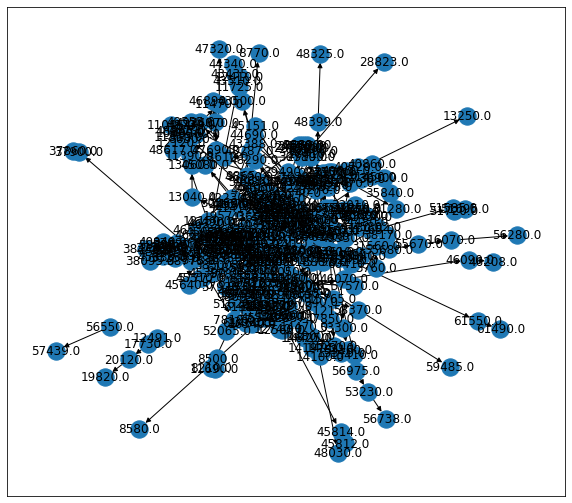

In [12]:
graph = nx.from_pandas_edgelist(routes_df, source = 'Origin', target = 'Destination',

                        edge_attr = 'Number of ships',create_using = nx.DiGraph())

#Draw graph 
plt.figure(figsize = (10,9))
nx.draw_networkx(graph)
plt.show()

#Create Graph Using Basemap 

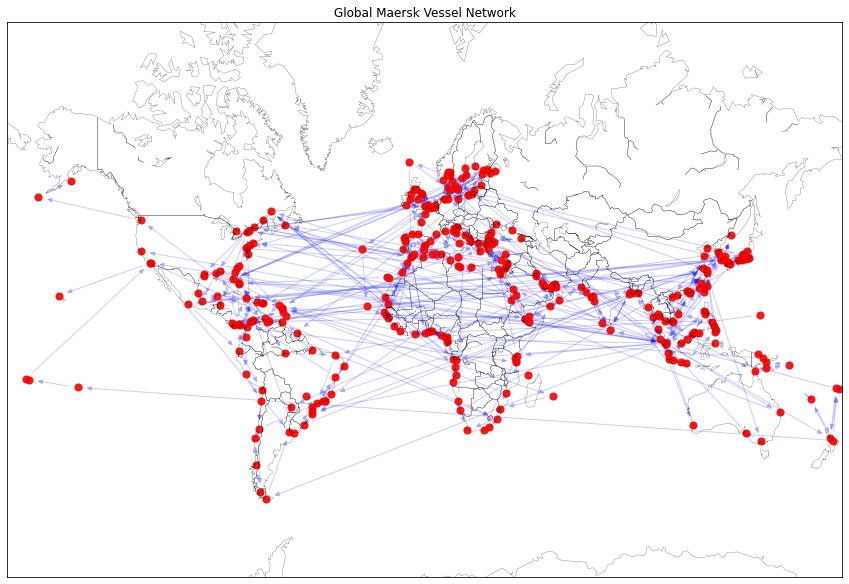

In [13]:
plt.figure(figsize = (12,8))
m = Basemap( projection='merc',llcrnrlat=-70,urcrnrlat=80,
             llcrnrlon=-180,urcrnrlon=180,resolution='c'  ,suppress_ticks=True)
 
 
mx, my = m(ports_df['Longitude'].values, ports_df['Latitude'].values)
pos = {}

for count, elem in enumerate (ports_df['World Port Index Number']):
     pos[elem] = (mx[count], my[count])

#Add all nodes egdes and attributes to basemap
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph.nodes(), 
                        node_color = 'r', alpha = 0.9, 
                       node_size = 50)
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='blue', 
                        alpha=0.2, arrows = True)


m.drawcountries(linewidth = 0.4)
m.drawcoastlines(linewidth=0.2)
plt.tight_layout()
plt.title('Global Maersk Vessel Network')
plt.savefig(r"C:\Users\jelme\OneDrive\Documenten\Princeton\AC - Junior Year\ORF387\map1.png", format = "png", dpi = 300)
plt.show()


# Communities 

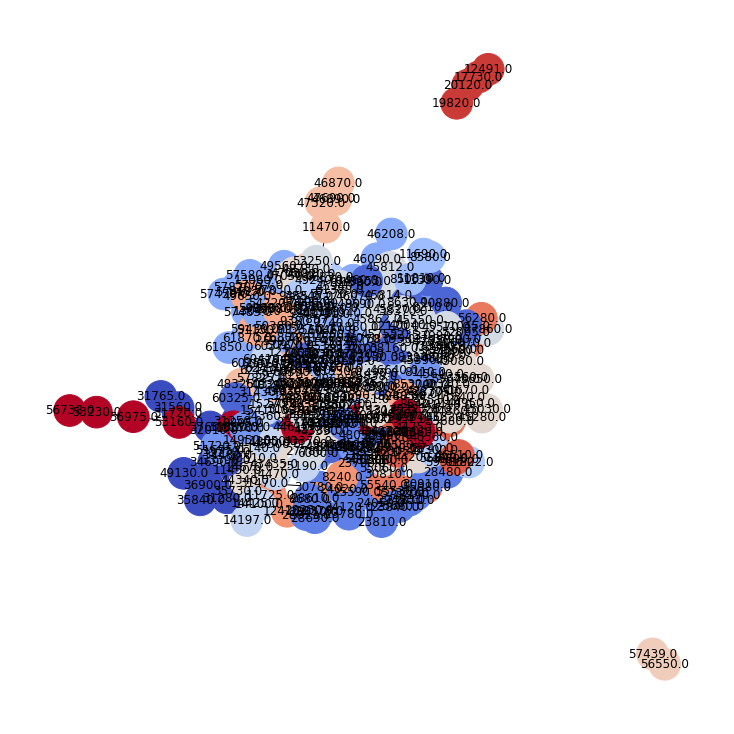

In [50]:
# Install and import the Louvain community detection algorithm
!pip uninstall community
!pip install python-louvain
import community.community_louvain

# Detect the community structure of the graph which maximises the modularity using the Louvain heuristices
partition = community.community_louvain.best_partition(graph,resolution=1)

# Set figure size that is larger than the default
plt.figure(figsize=(10,10))

nx.draw(graph, 
        with_labels=True,
        pos=nx.spring_layout(graph), # spring_layout is the default layout
        node_color=list(partition.values()),
        cmap=plt.cm.coolwarm,
        node_size=1000)


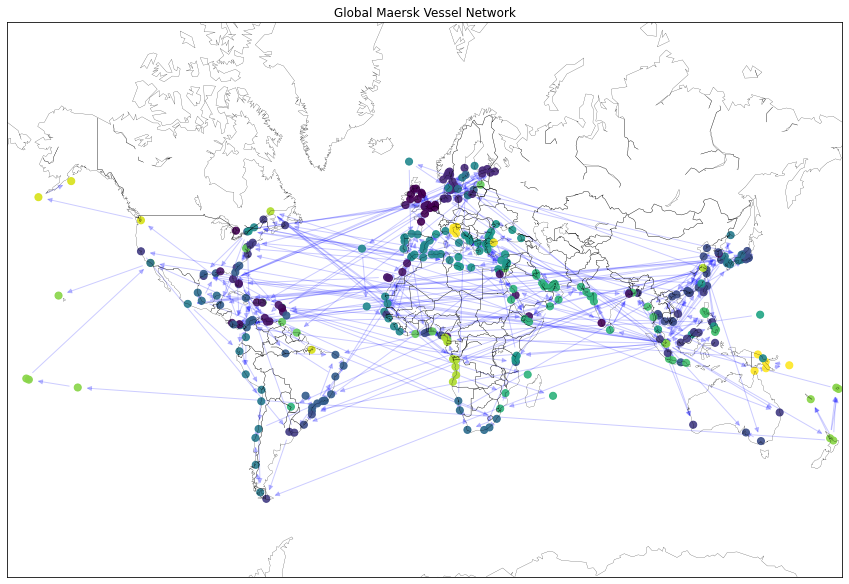

In [52]:
plt.figure(figsize = (12,8))
m = Basemap( projection='merc',llcrnrlat=-70,urcrnrlat=80,
             llcrnrlon=-180,urcrnrlon=180,resolution='c'  ,suppress_ticks=True)
 
 
mx, my = m(ports_df['Longitude'].values, ports_df['Latitude'].values)
pos = {}

for count, elem in enumerate (ports_df['World Port Index Number']):
     pos[elem] = (mx[count], my[count])

#Add all nodes egdes and attributes to basemap
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph.nodes(), 
                        node_color = list(partition.values()), alpha = 0.9, 
                       node_size = 50)
nx.draw_networkx_edges(G = graph, pos = pos, edge_color='blue', 
                        alpha=0.2, arrows = True)


m.drawcountries(linewidth = 0.4)
m.drawcoastlines(linewidth=0.2)
plt.tight_layout()
plt.title('Global Maersk Vessel Network')
plt.show()

#Create Global Port Graph 

In [ ]:
graph_ = nx.from_pandas_edgelist(all_ports, source = 'World Port Index Number',
                                target = 'World Port Index Number', 
                        create_using = nx.DiGraph())

graph2 = nx.from_pandas_edgelist(routes_df, source = 'Origin', target = 'Destination'

                        ,create_using = nx.DiGraph())
 
plt.figure(figsize = (12,8))

m = Basemap( projection='merc',llcrnrlat=-70,urcrnrlat=80,
             llcrnrlon=-180,urcrnrlon=180,resolution='c'  ,suppress_ticks=True)

#Calculate Position of ports 
mx, my = m(all_ports['Longitude'].values, all_ports['Latitude'].values)

pos_allports = {}

for count, elem in enumerate (all_ports['World Port Index Number']):

     pos_allports[elem] = (mx[count], my[count])

#Add all nodes to basemap
# Possible node shapes: so^>v<dph8.
nx.draw_networkx_nodes(G = graph, pos = pos_allports, nodelist = graph_.nodes(), 
                        node_color = 'r', alpha = 0.9, node_size = 30, label = 'Port')
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph2.nodes(), 
                        node_color = '#40AFD4', alpha = 0.9,node_shape = 'd', node_size = 130, label = 'Port Used by Maersk vessels')

m.drawcountries(linewidth = 0.2)
m.drawcoastlines(linewidth=0.2)
plt.tight_layout()
m.fillcontinents(color='tan',lake_color='lightblue')
plt.legend(fontsize = 10)
plt.title("Node mapping of all worldwide container ports", fontsize = 15)
plt.savefig(r"C:\Users\jelme\OneDrive\Documenten\Princeton\AC - Junior Year\ORF387\Port_map.png", format = "png", dpi = 300)
plt.show()


# Compute Betweenness Centrality Nodes


In [ ]:
### Betweenness Centrality 
from collections import Counter

# Find centrality values 
bet_centrality = nx.betweenness_centrality(graph, normalized = True, 
                                              endpoints = False)
  
# Finding 3 highest values
k = Counter(bet_centrality)
high = k.most_common(5)

print("Initial Dictionary:")
print(bet_centrality, "\n")
print("Dictionary with 5 highest values:")
print("Keys: Values")
 
for i in high:
    print(i[0]," :",i[1]," ")

# Turn into dataframe 
bet_df = pd.DataFrame.from_dict(high)
bet_df.columns = ['Origin', 'Centrality']
names = ['Singapore', 'Bremerhaven', 'Busan', 'Hamburg', 'Algeciras']
bet_df['Names'] = names
print(bet_df)


# Degree Centrality of Nodes

In [ ]:
### Degree Centrality 

# Find centrality values 
deg_centrality = nx.degree_centrality(graph)
  
# Finding 3 highest values
k = Counter(deg_centrality)
high_degree = k.most_common(5)


for i in high_degree:
    print(i[0]," :",i[1]," ")

# Turn into dataframe 
deg_df = pd.DataFrame.from_dict(high_degree)
deg_df.columns = ['Origin', 'Centrality']
names = ['Singapore', 'Jebel Ali', 'Busan', 'Port Tangier Mediterranee', 'Algeciras']
deg_df['Names'] = names
print(deg_df)



#close_centrality = nx.closeness_centrality(graph)
  

# Pagerank Centrality of Nodes 

In [ ]:
### Degree Centrality 

# Find centrality values 
pr_centrality = nx.pagerank(graph, alpha = 0.8)
  
# Finding 3 highest values
k = Counter(pr_centrality)
high_degree = k.most_common(5)

print("Initial Dictionary:")
print(pr_centrality, "\n")
print("Dictionary with 5 highest values:")
print("Keys: Values")
 
for i in high_degree:
    print(i[0]," :",i[1]," ")

# Turn into dataframe 
pr_df = pd.DataFrame.from_dict(high_degree)
pr_df.columns = ['Origin', 'Centrality']
names = ['Bremerhaven', 'Algericas', 'Colombo', 'Hamburg', 'Port Tangier Mediterranee']
pr_df['Names'] = names
print(pr_df)

In [ ]:
#Plot Nodes with Highest degree centrality on map 

graph_cen = nx.from_pandas_edgelist(all_ports, source = 'World Port Index Number',
                                target = 'World Port Index Number', 
                        create_using = nx.DiGraph())
graphMaersk_cen = nx.from_pandas_edgelist(routes_df, source = 'Origin', target = 'Destination'
                        ,create_using = nx.DiGraph())
graph_bet= nx.from_pandas_edgelist(bet_df, source = 'Origin', target = 'Origin',
                         create_using = nx.DiGraph())
graph_deg = nx.from_pandas_edgelist(deg_df, source = 'Origin', target = 'Origin',
                         create_using = nx.DiGraph())
graph_pr = nx.from_pandas_edgelist(pr_df, source = 'Origin', target = 'Origin',
                         create_using = nx.DiGraph())

plt.figure(figsize = (12,8))
m = Basemap( projection='merc',llcrnrlat=-70,urcrnrlat=80,
             llcrnrlon=-180,urcrnrlon=180,resolution='c'  ,suppress_ticks=True)

#Calculate Position of ports 
mx, my = m(all_ports['Longitude'].values, all_ports['Latitude'].values)
pos_allports = {}
for count, elem in enumerate (all_ports['World Port Index Number']):
     pos_allports[elem] = (mx[count], my[count])

#Add all nodes to basemap
nx.draw_networkx_nodes(G = graph, pos = pos_allports, nodelist = graph_cen.nodes(), 
                        node_color = 'r', alpha = 0.9, node_size = 30, label = 'Port')                                                  # All ports 
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graphMaersk_cen.nodes(), 
                        node_color = '#40AFD4', alpha = 0.9,node_shape = 'd', node_size = 130, label = 'Port Used by Maersk vessels')   # All Maersk Ports 
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph_bet.nodes(), 
                        node_color = 'Black', alpha = 0.9,node_shape = 'v', node_size = 600, label = 'High Betweenness')                 # 5 ports with Highest Betweenness Centrality 
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph_deg.nodes(), 
                        node_color = 'purple', alpha = 0.9,node_shape = 'v', node_size = 600, label = 'High Degree')                      # 5 ports with highest Degree Centrality
nx.draw_networkx_nodes(G = graph, pos = pos, nodelist = graph_pr.nodes(), 
                        node_color = 'blue', alpha = 0.9,node_shape = 'v', node_size = 600, label = 'High Pagerank') 

nx.draw_networkx_labels(G = graph, pos = pos, font_size=10,
		                    labels = {x:x for x in graph_deg.nodes()})

#Plot 
m.drawcountries(linewidth = 0.2), m.drawcoastlines(linewidth=0.2)
plt.tight_layout(), m.fillcontinents(color='tan',lake_color='lightblue')
plt.legend(fontsize = 10)
plt.title("Centrality of Ports", fontsize = 15)
plt.savefig(r"C:\Users\jelme\OneDrive\Documenten\Princeton\AC - Junior Year\ORF387\Port_map_Betweenness.png", format = "png", dpi = 300)
plt.show()

# Turnaround Time in Port 

In this Section I will compute the turnaround time in each port. There is nothing more expensive than having the largest container ship in the world lie still in a port due to ineffiencies on land with fueling and moving cargo from and onto the ship. So this is crucial 

In [ ]:
# Turn into numpy array
np.set_printoptions(suppress=True) 
schedule = np.genfromtxt('Maersk_data_all_time.csv', delimiter = ',', usecols=np.arange(0,9))
schedule = np.column_stack([schedule[2:,0], # Port ID
                            schedule[2:,7], # Ship Number 
                            schedule[2:,8]])# Time in Port 

print(schedule)

In [ ]:
#Create new array with all possible routes 
n = len(schedule[:,1])
TurnAround = np.zeros((n, 4)) #Port ID, AVG turnaround Time, count

for i in range (0,n-1): 
  # Check if PORT ID is already in matrix 
  if (schedule[i,0] in TurnAround[:i, 0]):
    loc = np.where(schedule[i,0] == TurnAround[:i, 0])
    TurnAround[loc, 2] = TurnAround[loc,2] + 1
    TurnAround[loc,1] =  (TurnAround[loc,1] + schedule[i,2])
    TurnAround[loc,3] = TurnAround[loc,1]/TurnAround[loc,2]
  # PORT ID is not in matrix yet 
  else: 
    TurnAround[i,0] = schedule[i,0] # Set port ID
    TurnAround[i,1] = schedule[i,2] # Set total turnaround 
    TurnAround[i,2] = 1             # Set count to 1 
    TurnAround[i,3] = TurnAround[i,1]/TurnAround[i,2] # Set AVG
    
#Delete empty rows
TurnAround = TurnAround[~np.all(TurnAround == 0, axis = 1)]

#Turn this dataset into pandas dataframe 
TurnAround = pd.DataFrame(TurnAround, columns = ['Port', 'Total', 'Count', 'AVG'])
print(TurnAround)


In [ ]:
 
m = len(TurnAround)
# Find centrality values 
bet_centrality = nx.betweenness_centrality(graph, normalized = True, 
                                              endpoints = False)
deg_centrality = nx.degree_centrality(graph)
pr_centrality = nx.pagerank(graph, alpha = 0.8)

# Creating dataframes 

#bet 
k = Counter(bet_centrality)
high = k.most_common(m)
bet_df = pd.DataFrame.from_dict(high)
bet_df.columns = ['Port', 'Betweenness']

# deg
k = Counter(deg_centrality)
high = k.most_common(m)
deg_df = pd.DataFrame.from_dict(high)
deg_df.columns = ['Port', 'Degree']

#PR 
k = Counter(pr_centrality)
high = k.most_common(m)
pr_df = pd.DataFrame.from_dict(high)
pr_df.columns = ['Port', 'PageRank']


In [ ]:
Data = pd.merge(left= TurnAround, right=bet_df)
Data = pd.merge(left = Data, right = deg_df)
Data = pd.merge(left = Data, right = pr_df)
# Drop nan from data 
Data = Data.dropna()
Data.isnull().values.any()

print(Data)


# Turn Around regression 

In [ ]:
from sklearn import linear_model

lm = linear_model.LinearRegression()
X = Data[['Betweenness']]
y = Data['AVG']
model = lm.fit(X,y)

In [ ]:
print(lm.score(X,y)) # R squared 
lm.coef_ # Coefficients 

In [ ]:
plt.scatter(X, y,color='g')
plt.plot(X, model.predict(X),color='k')
plt.title("Centrality and TurnAround Time", fontsize = 15)
plt.xlabel('Betweenness Centrality ')
plt.ylabel('Hours spent in Port')
plt.savefig(r"C:\Users\jelme\OneDrive\Documenten\Princeton\AC - Junior Year\ORF387\centrality.png", format = "png", dpi = 300)
plt.show()
